In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
df = pd.read_csv('CGM_glucose_data.csv')

In [3]:
df

,RecID,PtID,DeviceDtTm,Glucose
0,5850136,189,2000-11-10 04:37:41.000000,109
1,5850137,189,2000-11-10 04:47:43.000000,106
2,5850138,189,2000-11-10 04:57:38.000000,104
3,5850139,189,2000-11-10 05:07:37.000000,101
4,5850140,189,2000-11-10 05:17:40.000000,99
...,...,...,...,...
19625,13357166,189,2001-02-08 05:03:13.000000,381
19626,13357167,189,2001-02-08 05:13:20.000000,386
19627,13357168,189,2001-02-08 05:23:22.000000,394
19628,13357169,189,2001-02-08 05:33:23.000000,401


In [4]:
df['time_diff'] = 10
df['time'] = df.time_diff.cumsum()

In [5]:
ts = pd.DataFrame(df.time)
ys = pd.DataFrame(df['Glucose'])



In [6]:
# MODEL FIT AND PREDICTION

# Parameters of the predictive model. ph is Prediction horizon, mu is Forgetting factor.
ph = 100
###############################################################
#WE NEED TO CONVERT OUR PREDICTIVE HORIZON INTO A NUMBER OF
#TIME STEPS FOR INDEXING, BASED ON THE RESOLUTION OF OUR DATA.
#IN THIS CASE OUR DATA IS COLLECTED EVERY 10 MINUTES
##############################################################
ph_index = round(ph/10) 
mu = 0.9

In [7]:
#n_s = len(df)
n_s = 2000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


In [8]:
# At every iteration of the for loop a new sample from CGM is acquired.
for i in range(2, n_s+1):# start out with 2 leading datapoints
    ts_tmp = ts[0:i]
########################################################################
#INSTEAD OF USING THE CURRENT VALUE AS OUR PREDICTED VALUE IN TRAINING
#WE USE THE VALUE AT THE PREDICTIVE HORIZON INDEX
########################################################################
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)
    
    # The mu**k assigns the weight to the previous samples.
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k #More distant examples are downweighted exponentially
    weights = np.flip(weights, 0)
        

    # MODEL
    # Linear Regression.
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)# times are x, glucose readings are y
    # Coefficients of the linear model, y = mx + q 
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # PREDICTION
    tp = ts.iloc[i-1,0] #### don't add ph for prediction
    yp = m_tmp*tp + q_tmp #mx + b
      
    tp_pred[i-2] = tp + ph ### add ph to timestamp so that chart lines up with prediction
    yp_pred[i-2] = yp

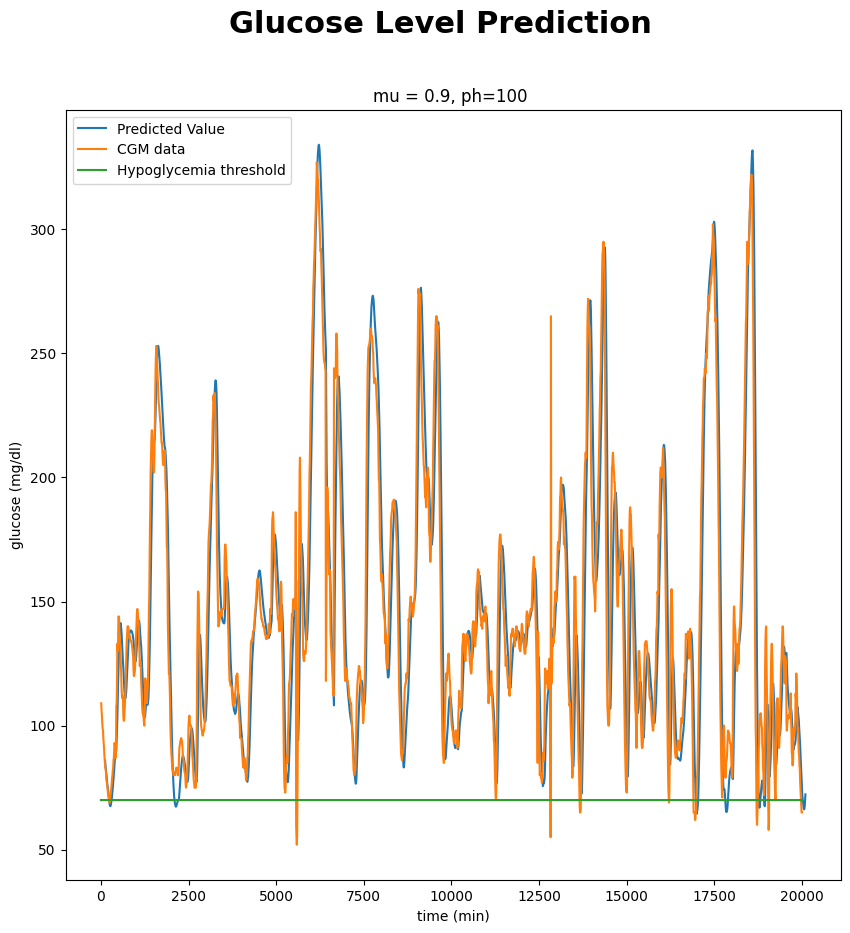

In [9]:
# Hypoglycemia threshold vector.    
t_tot = [l for l in range(n_s*10)]
hypoglycemiaTH = 70*np.ones(len(t_tot)) 
    
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Glucose Level Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='CGM data') 
ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax.set_xlabel('time (min)')
ax.set_ylabel('glucose (mg/dl)')
ax.legend()

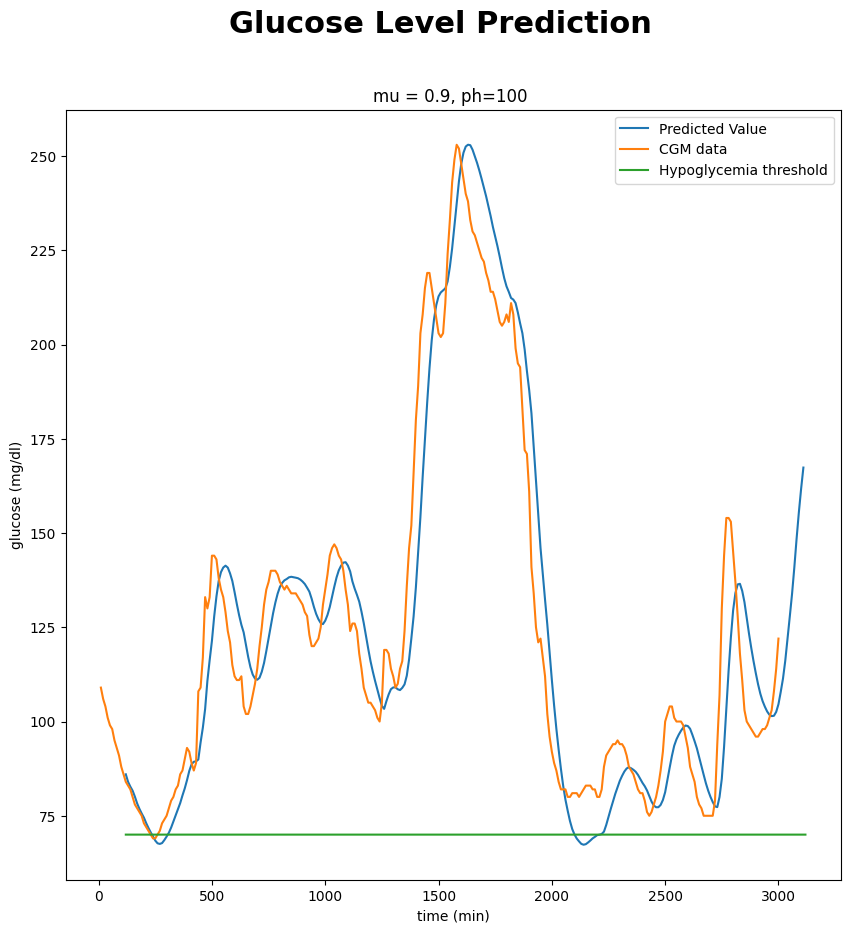

In [10]:
# PLOT EARLY
# Hypoglycemia threshold vector.    
t_tot = [l for l in range(int(min(tp_pred)), int(min(tp_pred+3000)))]
hypoglycemiaTH = 70*np.ones(len(t_tot)) 
    
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Glucose Level Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:300], yp_pred[0:300], label='Predicted Value') 
ax.plot(ts.iloc[0:300,0], ys.iloc[0:300,0], label='CGM data') 
ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax.set_xlabel('time (min)')
ax.set_ylabel('glucose (mg/dl)')
ax.legend()

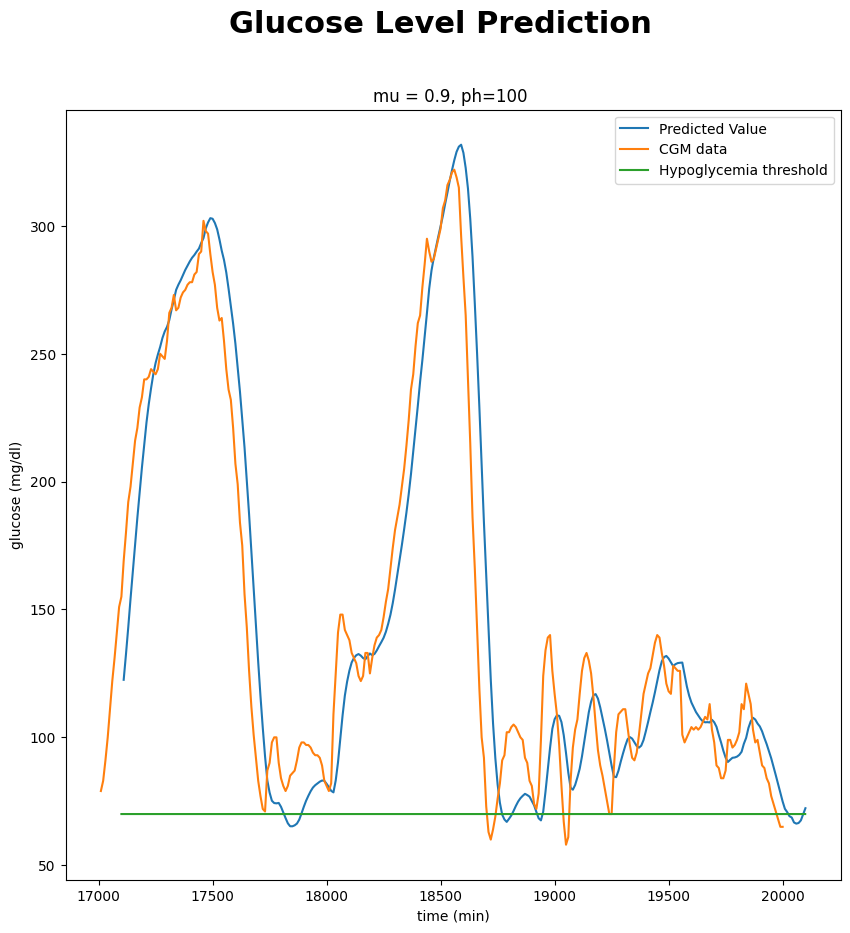

In [11]:
# PLOT LATE
# Hypoglycemia threshold vector.
maxt = max(tp_pred)
t_tot = [l for l in range(int(maxt)-3000, int(maxt))]
hypoglycemiaTH = 70*np.ones(len(t_tot)) 
    
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Glucose Level Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-300:], yp_pred[-300:], label='Predicted Value') 
ax.plot(ts.iloc[n_s-300:n_s,0], ys.iloc[n_s-300:n_s,0], label='CGM data') 
ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax.set_xlabel('time (min)')
ax.set_ylabel('glucose (mg/dl)')
ax.legend()

In [12]:
from sklearn.metrics import mean_squared_error as mse
#################################################################
#here we calculate the error by comparing the true value at the 
#predictive horizon to our predicted value
################################################################
print("MSE is", mse(ys[ph_index:2000+ph_index-1],yp_pred))

MSE is 394.93398542059833
